# BUILDING A PERSONALIZED MOVIE RECOMMENDATION SYSTEM
---
COLLABORATIVE AND CONTENT-BASED FILTERING

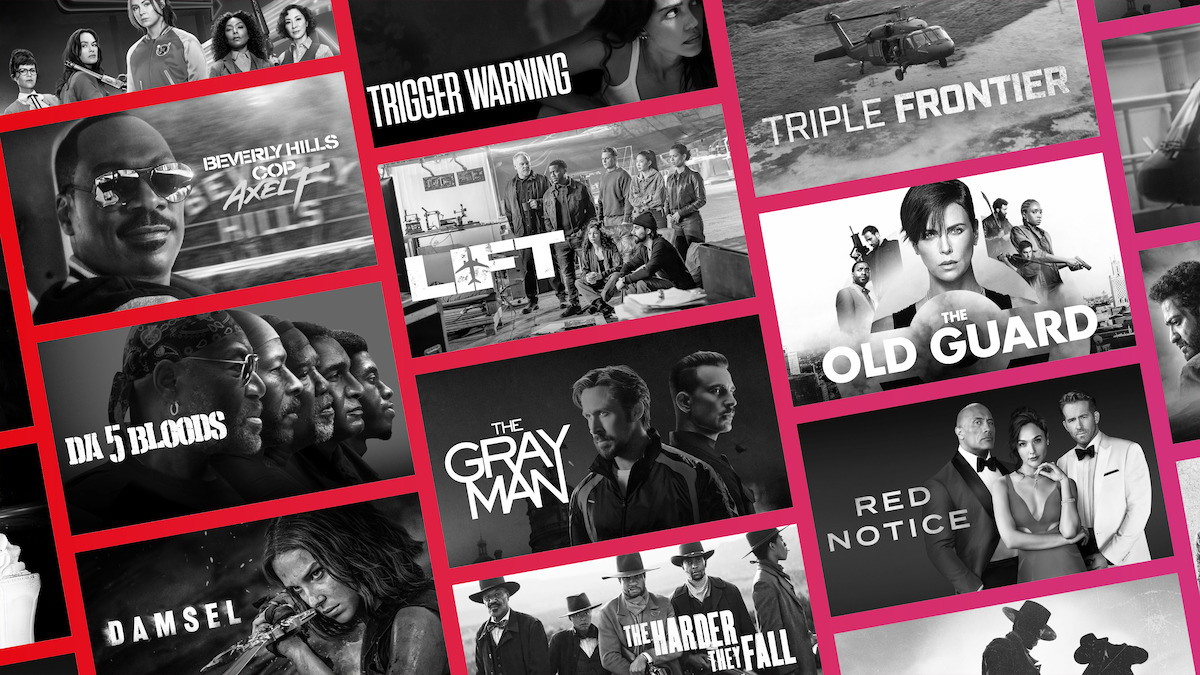

In [17]:
from IPython.display import Image, display
display(Image(filename='/content/AAAAQRC29H19twWKcTZ9Zpg4biJbGNaHF2GGIYNcLt4eZ6fvwugUJbuKxTjjMFPCS-y5P3ZePL57rupDtSkyUIJhv3P8leMJGMzszuG2CHNd65NwWPu5LeKxQkRNfNMHmxAwt7tmQZFk1VIrBd1aXr2AR5DM.jpg'))

## BUSINESS PROBLEM:
---


In today's digital world, users are overwhelmed with vast amounts of content, whether it's movies, products, music, or news articles. Businesses struggle to keep users engaged by providing personalized recommendations. Without an effective recommender system, customers may churn, engagement may decline, and businesses may lose revenue opportunities.


For example, in an online movie streaming platform, users need relevant and personalized movie recommendations based on their viewing history and preferences. A poor recommendation system may result in users struggling to find interesting content, leading to lower customer satisfaction and reduced subscription retention.

## OBJECTIVES
---


By implementing an effective recommender system, businesses can:

1. Increase user engagement and retention.

2. Improve customer satisfaction by offering relevant recommendations.

3. Enhance revenue opportunities through personalized marketing.



## GOALS
---

The goal of this study is to develop a personalized recommendation system that improves user experience and engagement by suggesting relevant content based on past interactions. This will be achieved using:

1. Collaborative Filtering: Predict user preferences based on similar users.

2. Content-Based Filtering: Recommend items similar to what a user has liked before.

3. Hybrid Approach (Optional): Combine multiple recommendation techniques for better accuracy.

4. Performance Evaluation: Assess the effectiveness of different models using evaluation metrics such as RMSE (Root Mean Squared Error) and Cosine Similarity

## IMPORTING THE NECCESSRY LIBRARIES
---

*  Import necessary libraries for data handling, visualization, and modeling.



In [4]:
!pip install surprise

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from surprise.prediction_algorithms import knns
from surprise import Reader, Dataset, SVD, KNNBasic, accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise.model_selection import cross_validate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505177 sha256=9abeccbb003fef5700ff3be7a649935b120682b2e84bea0ce50ba52793e34264
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


## LOADING THE DATASET
---
*   Read and explore the dataset.


In [8]:
# upload links datasets
links = pd.read_csv("links.csv")
print(links.shape)
# links.head(5)

#upload movies dataset
movies = pd.read_csv("movies.csv")
print(movies.shape)
# movies.head(5)

# upload ratings dataset
ratings = pd.read_csv("ratings.csv")
print(ratings.shape)
#ratings.head(5)


(9742, 3)
(9742, 3)
(100836, 4)


## DATA CLEANING

*   Merging the Datasets
*   Drop the irrelevant columns
*   Handle missing data.
*   Remove duplicate records, if any.
*   Clean or transform data types as necessary.

In [9]:
# Merge links and movies dataset using 'movieId'
links_movies = pd.merge(links, movies, on="movieId", how="inner")

# Now merge the result with ratings using 'movieId'
links_movies_ratings = pd.merge(links_movies, ratings, on="movieId", how="inner")

# Print shapes and display the first few rows
print(links_movies_ratings.shape)

# view the dataset
links_movies_ratings.head(5)

(100836, 8)


,movieId,imdbId,tmdbId,title,genres,userId,rating,timestamp
0,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [10]:
# drop columns
links_movies_ratings.drop(["imdbId", "tmdbId", "timestamp"], axis=1, inplace=True)
links_movies_ratings.head(5)

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


In [11]:
# handle missing value
links_movies_ratings.dropna(inplace=True)
links_movies_ratings.isnull().sum()

,0
movieId,0
title,0
genres,0
userId,0
rating,0


## DATA PREPROSSESSING

> This is conducted in order to transform raw data into a structured format suitable for machine learning models.

*   Extracting year from movie titles.
*   Converting Data into Model-Specific Format
*   Splitting Data for Training & Testing






In [12]:
# Extract year from movie title
links_movies_ratings['year'] = links_movies_ratings['title'].str.extract(r'\((\d{4})\)').astype(float)

# Remove the year from the title column
links_movies_ratings['title'] = links_movies_ratings['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)

# Display the updated dataframe
links_movies_ratings.head()


,movieId,title,genres,userId,rating,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1995.0
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,1995.0
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1995.0
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1995.0
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1995.0


Pipeline

In [13]:
# Data Preprocessing Pipeline
def preprocess_movies(movies_df):
    links_movies_ratings['genres'] = links_movies_ratings['genres'].str.replace('|', ' ')
    vectorizer = TfidfVectorizer(stop_words='english')
    genre_matrix = vectorizer.fit_transform(links_movies_ratings['genres'])
    return genre_matrix

movies_tfidf_matrix = preprocess_movies(movies)
print(movies_tfidf_matrix.shape)
print(" ")
print("There are 9742 movies in the dataset.")
print("There are 23 unique genre-related words in the dataset (after processing).")

(100836, 23)
 
There are 9742 movies in the dataset.
There are 23 unique genre-related words in the dataset (after processing).


Split and Train the Data

In [15]:
# Load dataset into Surprise format
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(links_movies_ratings[['userId', 'movieId', 'rating']], reader)

# Split the dataset into training and testing set
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

## EXPLORATORY DATA ANALYSIS (EDA)

*   Basic statistics.
*   Data visualization.



###  1.Rating

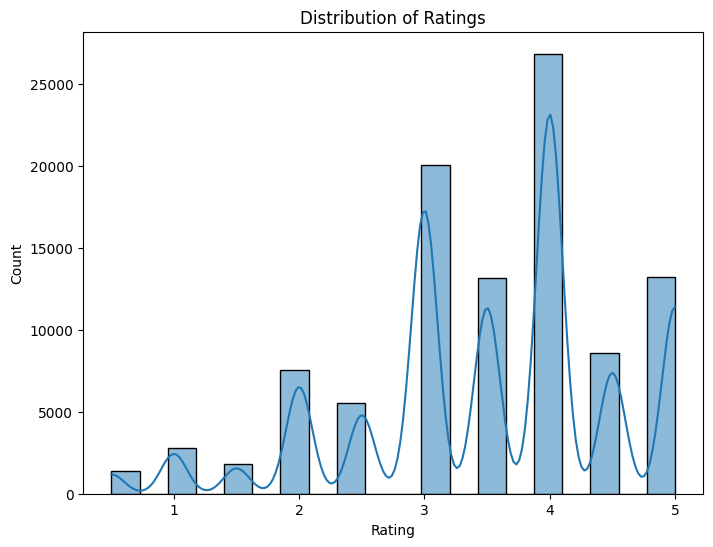

In [ ]:
# EDA for rating: plot histogram
plt.figure(figsize=(8, 6))
sns.histplot(links_movies_ratings['rating'], bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**EXPLANATION**

> The Histogram shows that majority of the movies are rated 4 while very few had a rating of 1.


> The distribution is skewed towards higher ratings, with the highest frequency at Rating 4.

> As the ratings increase from 1 to 5, the number of counts increases too, showing that more movies received higher ratings.


> This pattern suggests that, in this dataset, movies are more likely to receive higher ratings than lower ones.














### 2.Genre:

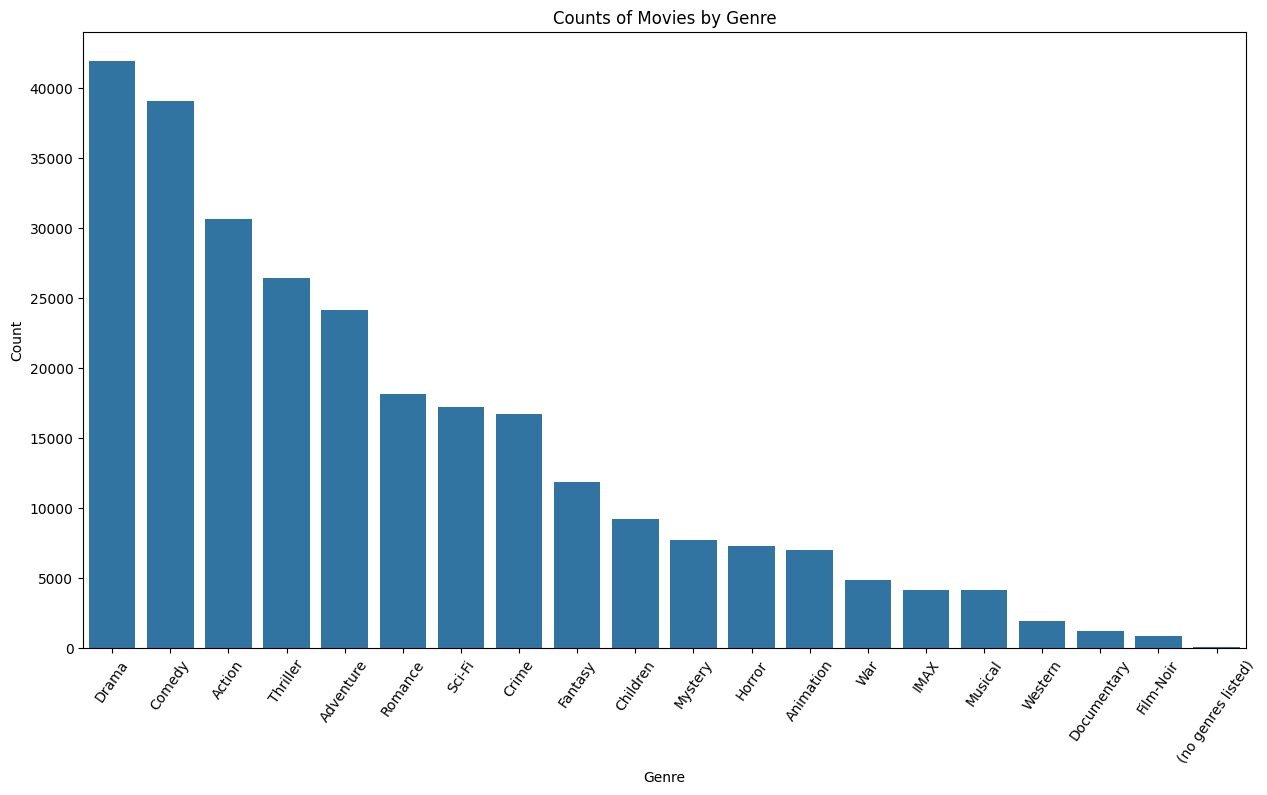

 
This means Drama is the most common genre in the dataset, followed by Comedy and Action


In [ ]:
# Each movie can have multiple genres separated by '|'. We need to split them.

# Create a copy of the dataframe to explode genres
df_genre = links_movies_ratings.copy()
# Replace '(no genres listed)' with NaN maybe
# Split genres by '|'
df_genre['genres'] = df_genre['genres'].fillna('')
df_genre = df_genre.assign(genre = df_genre['genres'].str.split('\|'))


# Explode to have one genre per row
df_exploded = df_genre.explode('genre')

# Count per genre overall
genre_counts = df_exploded['genre'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Plot genre counts
plt.figure(figsize=(15, 8))
sns.barplot(data=genre_counts, x='genre', y='count')
plt.title('Counts of Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=55)
plt.show()
print(" ")
print("This means Drama is the most common genre in the dataset, followed by Comedy and Action")

**EXPLANATION**

> Drama is the most frequent genre, with over 40,000 movies. It is followed closely by Comedy and Action, which also have large counts. Genres such as Thriller, Adventure, and Romance appear in the middle range, with counts significantly lower than Drama but still in the high teens to low 20,000s



> On the other end of the spectrum, genres like Western, Documentary, and Film-Noir are much less frequent, with counts well under 5,000.




### 3.Rating by Title

In [ ]:
# Rating group by title
avg_rating_title = links_movies_ratings.groupby('title')['rating'].mean().reset_index()
avg_rating_title = avg_rating_title.sort_values('rating', ascending=False)
print('Average rating per title:')
print(avg_rating_title.head(10))
print(" ")
print("The top 5 Most rated movies are Hollywood Chainsaw Hookers, Calcium Kid,Chinese Puzzle (Casse-tête chinois), Raise Your Voice and Rain")
print(" ")
print(avg_rating_title.tail(10))
print("The low rated movies are Indestructible Man,Yongary: Monster from the Deep,  Don't Look Now, Superfast! and Anaconda: The Offspring")

Average rating per title:
                                           title  rating
3863                  Hollywood Chainsaw Hookers     5.0
1473                            Calcium Kid, The     5.0
1692         Chinese Puzzle (Casse-tête chinois)     5.0
6742                            Raise Your Voice     5.0
6738                                        Rain     5.0
6727                                   Radio Day     5.0
8463                          Thousand Clowns, A     5.0
4013                           Hunting Elephants     5.0
1183                              Blue Planet II     5.0
760   Ballad of Narayama, The (Narayama bushiko)     5.0
 
The top 5 Most rated movies are Hollywood Chainsaw Hookers, Calcium Kid,Chinese Puzzle (Casse-tête chinois), Raise Your Voice and Rain
 
                                   title  rating
4865              Leprechaun 4: In Space     0.5
7515                             Skyline     0.5
7099  Rust and Bone (De rouille et d'os)     0.5
7965        

### 4.Rating per Genre

In [ ]:
# calculate average rating per genre
avg_rating_genre = df_exploded.groupby('genre')['rating'].mean().reset_index()
avg_rating_genre = avg_rating_genre.sort_values('rating', ascending=False)
print('Average rating per genre:')
print(" ")
print(avg_rating_genre)
print(" ")
print("The genres that are highly rated are Film-Noir, War, Documentary, Crime and Drama ")
print("The low rated genre were Horror,Comedy, Children,Actions and Sci-Fi ")

Average rating per genre:
                 genre    rating
10           Film-Noir  3.920115
18                 War  3.808294
7          Documentary  3.797785
6                Crime  3.658294
8                Drama  3.656184
14             Mystery  3.632460
3            Animation  3.629937
12                IMAX  3.618335
19             Western  3.583938
13             Musical  3.563678
2            Adventure  3.508609
15             Romance  3.506511
17            Thriller  3.493706
9              Fantasy  3.491001
0   (no genres listed)  3.489362
16              Sci-Fi  3.455721
1               Action  3.447984
4             Children  3.412956
5               Comedy  3.384721
11              Horror  3.258195


## BUILD THE RECOMMENDER SYSTEM


### A. Collaborative Filtering Using Surprise

In [ ]:
# Converting Data into Model-Specific Format
# For Surprise Library (Collaborative Filtering Model):

# Define the rating scale
reader = Reader(rating_scale=(0.5, 5.0))

# Load data into Surprise Dataset
data = Dataset.load_from_df(links_movies_ratings[['userId', 'movieId', 'rating']], reader)

# Load dataset into Surprise format
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(links_movies_ratings[['userId', 'movieId', 'rating']], reader)

# Train model using SVD
model = SVD()
# Import cross_validate from surprise.model_selection

cross_validate(model, data, cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8748  0.8701  0.8726  0.8760  0.8713  0.8729  0.0022  
MAE (testset)     0.6715  0.6650  0.6728  0.6723  0.6699  0.6703  0.0028  
Fit time          1.56    1.59    1.59    1.57    1.57    1.57    0.01    
Test time         0.10    0.10    0.10    0.10    0.35    0.15    0.10    


{'test_rmse': array([0.87477704, 0.87005596, 0.87260726, 0.87595396, 0.87131472]),
 'test_mae': array([0.67153269, 0.66500372, 0.67275003, 0.67231687, 0.66986281]),
 'fit_time': (1.5587129592895508,
  1.5860569477081299,
  1.5892562866210938,
  1.5710761547088623,
  1.5672359466552734),
 'test_time': (0.10378479957580566,
  0.10296154022216797,
  0.10126829147338867,
  0.10281133651733398,
  0.346189022064209)}

In [ ]:
# Train a basic SVD model on the training set
algo = SVD(random_state=42)
algo.fit(trainset)

# Predict on the testset
predictions = algo.test(testset)

# Compute and print RMSE
rmse = accuracy.rmse(predictions)

print('RMSE on test set:', rmse)
print('Number of predictions:', len(predictions))

RMSE: 0.8745
RMSE on test set: 0.8744981021934208
Number of predictions: 25209


### B. Content-Based Filtering (Using Cosine Similarity)

In [ ]:
# Convert movie genres into a TF-IDF matrix
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(movies['genres'].fillna(""))

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to recommend movies
def recommend(movie_title, num_recommendations=5):
    idx = movies[movies['title'] == movie_title].index[0]
    scores = list(enumerate(cosine_sim[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    recommended_movie_indices = [i[0] for i in scores[1:num_recommendations+1]]
    return movies.iloc[recommended_movie_indices]['title']

# Example recommendation
recommend("Toy Story (1995)")


ValueError: empty vocabulary; perhaps the documents only contain stop words

## MODEL EVALUATION

In [ ]:
# Define similarity options
sim_options = {
    'name': 'cosine',  # Use cosine similarity to measure the similarity between items
    'user_based': False  # Set to False for item-based filtering (True would be for user-based filtering)
}

# Build the model using the KNNBasic algorithm
item_cf_model = KNNBasic(sim_options=sim_options)

# Train the model on the training set
item_cf_model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
trainset, testset = train_test_split(data, test_size=0.2)
model.fit(trainset)
predictions = model.test(testset)

# Compute RMSE
rmse = accuracy.rmse(predictions)
print('RMSE:', rmse)


RMSE: 0.8639
RMSE: 0.8638545783772473


## MAKING A PREDICTION

In [ ]:
sim_cosine = {"name": "cosine", "user_based": False}
basic_cosine = knns.KNNBasic(sim_options=sim_cosine)
basic_cosine.fit(trainset)
predictions = basic_cosine.test(testset)
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9717
0.9716548174439473



Predict ratings for a user-movie pair.

In [ ]:
user_id = 1
movie_id = 9745
predicted_rating = model.predict(user_id, movie_id)
print(f"Predicted rating: {predicted_rating.est}")

Predicted rating: 4.187465617028602


In [ ]:
user_id = 1
movie_id = 50
predicted_rating = model.predict(user_id, movie_id)
print(f"Predicted rating: {predicted_rating.est}")


Predicted rating: 5.0


In [ ]:
# Define movie titles
movie_title_1 = "Avenger"
movie_title_2 = "Ex Drummer"

# Find the movie IDs for the given titles from the combined DataFrame
movie_id_1 =links_movies_ratings[links_movies_ratings['title'].str.contains(movie_title_1, case=False, na=False)]['movieId'].values
movie_id_2 = links_movies_ratings[links_movies_ratings['title'].str.contains(movie_title_2, case=False, na=False)]['movieId'].values

# Check if the movie titles were found
if len(movie_id_1) > 0:
    rating_1 = links_movies_ratings[links_movies_ratings['movieId'] == movie_id_1[0]]['rating'].values[0]
    print(f"Movie: {movie_title_1}, Rating: {rating_1}")
else:
    print(f"Movie '{movie_title_1}' not found.")

if len(movie_id_2) > 0:
    rating_2 = links_movies_ratings[links_movies_ratings['movieId'] == movie_id_2[0]]['rating'].values[0]
    print(f"Movie: {movie_title_2}, Rating: {rating_2}")
else:
    print(f"Movie '{movie_title_2}' not found.")


Movie: Avenger, Rating: 3.0
Movie: Ex Drummer, Rating: 5.0


## MAKE RECOMMENDATION BASED ON A MOVIE TITLE

In [ ]:
def get_similar_movies(movie_title, model, trainset, movies_df, top_n=5):
    # Find the movie ID for the given title
    movie_id = movies_df[movies_df['title'].str.contains(movie_title, case=False, na=False)]['movieId'].values

    # Convert the movieId to an internal ID used by Surprise (trainset)
    movie_inner_id = trainset.to_inner_iid(movie_id[0])

    # Get the top N most similar movies using the KNN model's get_neighbors function
    neighbors = model.get_neighbors(movie_inner_id, k=top_n)

    # Map internal IDs back to movie titles
    similar_titles = [(movies_df[movies_df['movieId'] == int(trainset.to_raw_iid(neighbor))]['title'].values[0])
                      for neighbor in neighbors]

    return similar_titles

# Example usage
recommend("Toy Story", 5)

,title
1706,Antz (1998)
2355,Toy Story 2 (1999)
2809,"Adventures of Rocky and Bullwinkle, The (2000)"
3000,"Emperor's New Groove, The (2000)"
3568,"Monsters, Inc. (2001)"


In [ ]:
# Movie title input
movie_title = "Shooter"

# Get the top 5 similar movies
recommended_movies = get_similar_movies(movie_title, item_cf_model, trainset, links_movies_ratings, top_n=5)

# Print the recommended movies (only titles)
if isinstance(recommended_movies, list):
    print(f"Top 5 similar movies to '{movie_title}':")
    for movie in recommended_movies:
        print(movie)
else:
    print(recommended_movies)

Top 5 similar movies to 'Shooter':
Sum of All Fears, The (2002)
Working Girl (1988)
A Million Ways to Die in the West (2014)
Enough (2002)
Mothman Prophecies, The (2002)


In [ ]:
# Movie title input
movie_title = "Hollywood Chainsaw Hookers"

# Get the top 5 similar movies
recommended_movies = get_similar_movies(movie_title, item_cf_model, trainset, links_movies_ratings, top_n=5)

# Print the recommended movies (only titles)
if isinstance(recommended_movies, list):
    print(f"Top 5 similar movies to '{movie_title}':")
    for movie in recommended_movies:
        print(movie)
else:
    print(recommended_movies)


Top 5 similar movies to 'Hollywood Chainsaw Hookers':
Ferris Bueller's Day Off (1986)
My Big Fat Greek Wedding (2002)
101 Dalmatians (One Hundred and One Dalmatians) (1961)
Meet the Parents (2000)
American President, The (1995)


## MAKE RECOMMENDATION BASED ON GENRE

Explode Genres and Count Views per Genre

In [ ]:
# Split genres into separate rows
movies['genres'] = movies['genres'].str.split('|')
movies_exploded = movies.explode('genres')

# Merge ratings with movies dataset
user_genre_data = ratings.merge(movies_exploded, on="movieId")

# Count number of times each user has watched a genre
user_genre_counts = user_genre_data.groupby(['userId', 'genres']).size().reset_index(name="count")

# Display the first few rows
print("This table shows how many times each user watched a specific genre.")
print(" ")
user_genre_counts.head()

This table shows how many times each user watched a specific genre.
 


,userId,genres,count
0,1,Action Adventure,3
1,1,Action Adventure Children Comedy Fantasy,2
2,1,Action Adventure Children Fantasy Mystery Thri...,1
3,1,Action Adventure Comedy,1
4,1,Action Adventure Comedy Fantasy,1


In [ ]:
# Find the most-watched genre for each user
favorite_genres = user_genre_counts.loc[user_genre_counts.groupby('userId')['count'].idxmax()]

# Display a few users and their favorite genres
print("This finds the genre each user watches the most")
print(" ")
favorite_genres.head()

This finds the genre each user watches the most
 


,userId,genres,count
14,1,Action Adventure Sci-Fi,11
132,2,Comedy,3
168,3,Drama,4
211,4,Comedy,21
287,5,Crime Drama,4


In [ ]:
def recommend_by_genre(user_id, num_recommendations=5):
    # Get user's favorite genre
    fav_genre = favorite_genres.loc[favorite_genres['userId'] == user_id, 'genres'].values[0]

    # Find movies that belong to this genre
    recommended_movies = movies_exploded[movies_exploded['genres'] == fav_genre]

    # Sort by average rating (or another metric)
    # Ensure 'movieId' is treated as numeric before merging
    recommended_movies['movieId'] = pd.to_numeric(recommended_movies['movieId'])
    top_movies = recommended_movies.merge(ratings, on='movieId').groupby(['movieId', 'title'])['rating'].mean().reset_index()

    # Sort and get top recommendations
    top_movies = top_movies.sort_values(by='rating', ascending=False)

    return top_movies[['title', 'rating']].head(num_recommendations)

# Example usage:
print("This function finds movies that match the user's preferred genre and recommends the top-rated ones.")
print(" ")
recommend_by_genre(1, 5)  # Recommend 5 movies for user 1

This function finds movies that match the user's preferred genre and recommends the top-rated ones.
 


,title,rating
1,Star Wars: Episode IV - A New Hope (1977),4.231076
4,Star Wars: Episode V - The Empire Strikes Back...,4.215640
5,Star Wars: Episode VI - Return of the Jedi (1983),4.137755
46,Guardians of the Galaxy (2014),4.050847
53,Thor: Ragnarok (2017),4.025000
